In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyfonts import load_bunny_font, load_font
from highlight_text import ax_text

In [2]:
# Custom fonts
font_title = load_bunny_font("Architects Daughter")
font_black = load_font("https://github.com/indestructible-type/Cooper/blob/main/fonts/ttf/Cooper-Black.ttf?raw=true")
font_regular = load_font("https://github.com/indestructible-type/Cooper/blob/main/fonts/ttf/Cooper-Regular.ttf?raw=true")

In [3]:
# Accesing OSM data
# Place name
place = "Ilha do Corvo"

# Tags
tags = {
    "natural": ["grassland", "heath", "tundra", "scrub", "beach", "wetland", "bare_rock", "mud"],    
    "landuse": ["farmland", "retail", "residential", "forest", "meadow", "commercial", "industrial"],  
    "water": ["lake", "reservoir", "harbour"],
    "waterway": "stream",
    "highway": ["tertiary", "residential", "unclassified"]
}
# Download OSM features
osm = ox.features.features_from_place(place, tags)

# Filter out points
osm = osm[osm.geom_type != "Point"]

# List of column names to keep
columns_to_keep = ["geometry", "natural", "landuse", "water", "waterway", "highway", "addr:city", "name"]
# Filters for the relevant columns
osm = osm[columns_to_keep]

In [4]:
# Function to controll highway linewidth
def highway_linewidth(row):    
    if row["highway"] in ["tertiary"]:  
        return 0.5
    elif row["highway"] in ["residential"]:
        return 0.4     
    else:
        return 0.3

In [5]:
# Colors dictionary
colors = {
    "grassland": {"color": "#d3ecac"}, 
    "heath": {"color": "#d7da9b"}, 
    "scrub": {"color": "#cbd8a9"}, 
    "tundra": {"color": "#A4D579"},   
    "mud": {"color": "#D8CBAE"}, 
    "wetland": {"color": "#3790B9"},   
    "bare_rock": {"color": "#B9C4B4"},    
    "beach": {"color": "#BC3739"}, 
    "farmland": {"color": "#eef0d4"}, 
    "forest": {"color": "#a5ca84"}, 
    "residential": {"color": "#e3c928"},
    "commercial": {"color": "#A572CE"}, 
    "industrial": {"color": "#A572CE"}, 
    "retail": {"color": "#A572CE"}, 
    "meadow": {"color": "#d3ecac"},   
    "lake": {"color": "#64C8FB"}, 
    "reservoir": {"color": "#64C8FB"}, 
    "harbour": {"color": "#15326F"}
}

In [6]:
# Text to add
txt = '''
    Corvo is the smallest island of
    the Azores, located approximately
    1360 km of mainland Portugal
    and 3618 km to Boston, MA, USA.      
    
    Corvo is known as one of the best
    places in the world for bird
    watching and hiking and
    considered a World Biosphere
    Reserve by UNESCO.        
    
    The island was discovered around 
    1452 by Portuguese explorer Diogo
    Teive but settlement did not occur 
    until 1580.     
    
    The only village is <Vila do Corvo>
    which is the smallest municipality
    in all of the Azores. It is the only
    Portuguese top-level municipality
    without a civil parish.    
    
    <Praia da Areia> is the only sandy
    beach on the island, offering 
    fine black volcanic sand.
    
    The volcanic crater, the <Caldeirão>,
    provides an impressive view. The
    lagoon that was formed in this
    natural depression is 300 m deep
    and occupies a perimeter of
    3.7 km, with several small lagoons
    and almost a dozen river islets.    

    Area:              17.12 km2 
    Coastline:         21.49 km 
    Highest elevation: 720 m 
    Population (2023): 435 
    '''

In [7]:
# Filter for places to annotate
village = osm[osm["addr:city"]=="Vila do Corvo"]
beach = osm[osm["name"]=="Praia da Areia"]
caldera = osm[osm["name"]=="Lagoa do Caldeirão"]

# Concatenate dfs
txt_gdf = pd.concat([village, beach, caldera], ignore_index=True)
# List of labels
labels = ["Vila do Corvo", "Praia da Areia", "Caldeirão"]

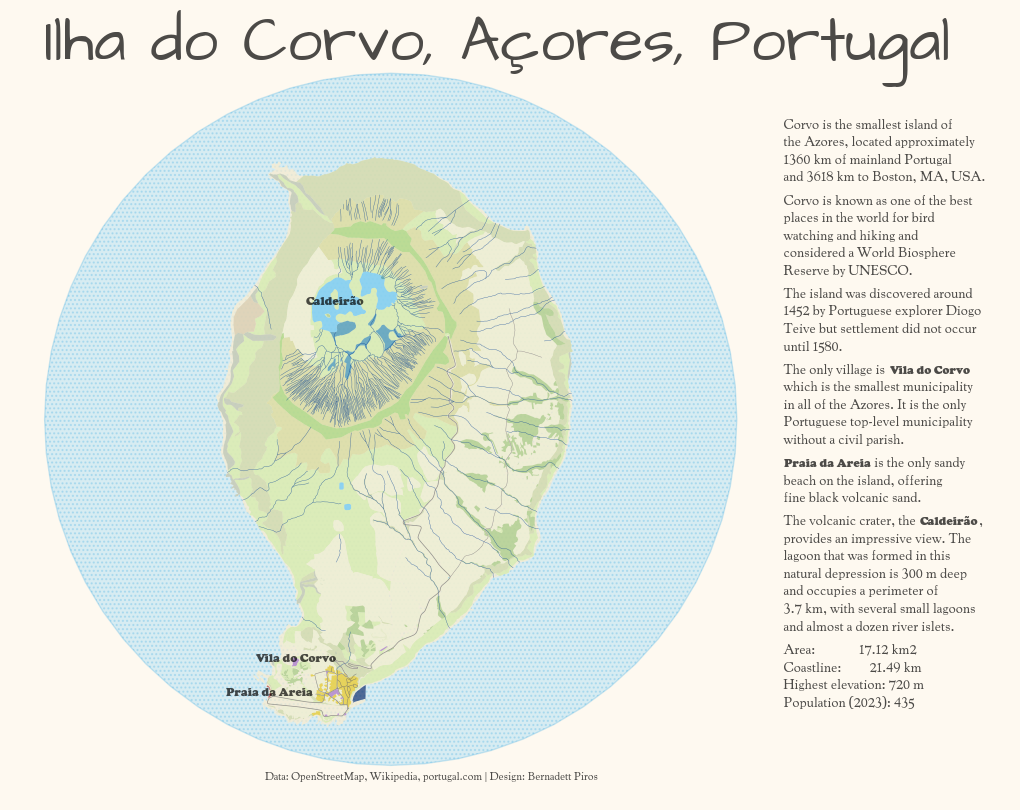

In [8]:
# Create figure and set background color
fig, ax = plt.subplots(figsize=(12, 8), facecolor="#fef9f0")

# Get place boundary
area = ox.geocode_to_gdf(place)

# Reproject to EPSG:3857 (Web Mercator)
area = area.to_crs(epsg=3857)

# Get the centroid of the area as a Point object
point = area.geometry.centroid.iloc[0]  

# Convert the point to a GeoSeries and ensure CRS matches the area CRS
point_gdf = gpd.GeoSeries([point], crs="EPSG:3857")  

# Buffer the point in meters 
buffer = point_gdf.buffer(5000)  

# Convert the buffer back to EPSG:4326 
buffer_4326 = buffer.to_crs(epsg=4326)
area = area.to_crs(epsg=4326)
buffer_4326.plot(ax=ax, color="#64C8FB", hatch="....", ec="#35a9e3", alpha=0.25)

# Area
area.plot(ax=ax, facecolor="#FDEDCE", alpha=0.7) 

# Natutal, landuse, water
# Lopp through the colors dictionary
for key, props in colors.items():
    # Create subset
    subset = osm[(osm["natural"] == key) | (osm["landuse"] == key) | (osm["water"] == key)]

    # If subset is empty skip to the next key
    if subset.empty:
        continue

    # Plot natutal, landuse, water
    subset.plot(
        ax=ax,
        facecolor=props["color"],   
        alpha=0.7
    )

# Waterway (stream)
flow_water = osm[osm["waterway"] =="stream"] 
flow_water.plot(ax=ax, linewidth=0.3, color="#003b94", alpha=0.7) 

# Roads
roads = osm[~osm["highway"].isna()]
roads = roads.copy()
roads["linewidth"] = roads.apply(highway_linewidth, axis=1)
roads.plot(ax=ax, linewidth=roads["linewidth"], ec="dimgray", alpha=0.7) 

# Project to 3857 metric CRS 
sub_proj = txt_gdf.to_crs(epsg=3857)
# Compute centroids 
centroids = sub_proj.geometry.centroid
# Convert centroids back to 4326 for plotting
centroids = centroids.to_crs(epsg=4326)

# Add centroids and text annotations 
for c, label in zip(centroids, labels):
    ax.text(c.x, c.y, label, font=font_black, size="small", alpha=0.7, ha="center")

# Create a child axes
text_ax = ax.inset_axes([1, 0, 0.3, 1])  
# Turn off child axis
text_ax.axis("off")

# Add annotations
ax_text(0, 0.5, s=txt, size="medium", font=font_regular, alpha=0.7, va="center", ax=text_ax,
            highlight_textprops=[
                {"font": font_black, "size":"small"},
                {"font": font_black, "size":"small"},
                {"font": font_black, "size":"small"}            
            ])

# Turn off the axis
ax.axis("off")

# Add title
fig.text(0.555, 0.95, "Ilha do Corvo, Açores, Portugal", font=font_title, size=45, alpha=0.7, ha="center")

# Add caption
fig.text(0.5, 0.05, "Data: OpenStreetMap, Wikipedia, portugal.com | Design: Bernadett Piros", size=8, font=font_regular, alpha=0.7, ha="center")

# Adjust the padding between and around axes
plt.tight_layout()
plt.show()

#fig.savefig("corvo.png", bbox_inches="tight", pad_inches=0.2) 